# Final Project: Car vs Non-car
### Team 07

- A01281209 - Gabriel Bermúdez 
- A01570288 - Angel Guevara 
- A01656259 - Einar López 
- A01702218 - Valeria Betancourt

## 1 - Packages

Let's first import all the packages we will need. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used to test our model with our pictures.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## 2 - Dataset

We will use a "Car vs Non-Car" dataset.

In [2]:
classes  = [b'non-car', b'car']
pathCar = './datasets/car/'
pathNonCar = './datasets/flower/'

# Get filenames of the images
arrCar = os.listdir(pathCar)
arrNonCar = os.listdir(pathNonCar)

# Label the data
arrCar = [[fname, 1] for fname in arrCar]
arrNonCar = [[fname, 0] for fname in arrNonCar]

# Put them together
arrData = arrCar + arrNonCar

# Sort by filaname to make sure that the filenames have a fixed order before shuffling
np.random.seed(1)
arrData.sort(key=lambda data: data[0])
np.random.shuffle(arrData)

# Add path
arrData = [[pathCar + fname, label] if label == 1 else [pathNonCar + fname, label] for fname, label in arrData]

# Open images and convert them to numpy arrays, each cell is compose by an RGB image [0] and label [1]
data = np.array([[np.array(Image.open(fname).convert('RGB')), label] for fname, label in arrData])

In [3]:
# Train %70, dev %15, test %15
train_size = int(len(arrData) * .70)
dev_size = int(len(arrData) * .15)
test_size = int(len(arrData) * .15)

# Get training set
train_x_orig = np.array([img[0] for img in data[:train_size]])
train_y = np.array([img for img in data[:train_size, 1]]).reshape(1, -1)
# Get dev set
dev_x_orig = np.array([img[0] for img in data[train_size:train_size + dev_size]])
dev_y = np.array([img for img in data[train_size:train_size + dev_size, 1]]).reshape(1, -1)
# Get test set
test_x_orig = np.array([img[0] for img in data[train_size + dev_size:train_size + dev_size + test_size]])
test_y = np.array([img for img in data[train_size + dev_size:train_size + dev_size + test_size, 1]]).reshape(1, -1)

print(train_x_orig.shape)
print(train_y.shape)
print(dev_x_orig.shape)
print(dev_y.shape)
print(test_x_orig.shape)
print(test_y.shape)

(2800, 128, 128, 3)
(1, 2800)
(600, 128, 128, 3)
(1, 600)
(600, 128, 128, 3)
(1, 600)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-car picture.


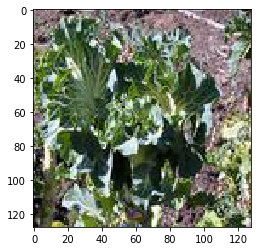

In [4]:
# Example of a picture
index = 15
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

We can now explore our dataset.

In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_dev = dev_x_orig.shape[0]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of dev examples: " + str(m_dev))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("dev_x_orig shape: " + str(dev_x_orig.shape))
print ("dev_y shape: " + str(dev_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 2800
Number of dev examples: 600
Number of testing examples: 600
Each image is of size: (128, 128, 3)
train_x_orig shape: (2800, 128, 128, 3)
train_y shape: (1, 2800)
dev_x_orig shape: (600, 128, 128, 3)
dev_y shape: (1, 600)
test_x_orig shape: (600, 128, 128, 3)
test_y shape: (1, 600)


We need to reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [6]:
# Reshape the training, dev and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
dev_x = dev_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("dev_x's shape: " + str(dev_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (49152, 2800)
dev_x's shape: (49152, 600)
test_x's shape: (49152, 600)


$49,152$ equals $128 \times 128 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of our model
### 3.1 - L-layer deep neural network

Here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

### 3.2 - General methodology

Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

## 4 - L-layer Neural Network

In [8]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost at beginning and end
        if print_cost and (i == 0 or i == num_iterations - 1):
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 5 - Training and finding the best model

### 5.1 Base model
__Data separation:__
- 20% train
- 15% dev
- 15% test

__Network structure:__
- layers_dims = [49152, 20, 7, 5, 1] #  4-layer model

__Learning Rate:__
- 0.0075

__Number of iterations:__
- 2500

Cost after iteration 0: 0.693275
Cost after iteration 2499: 0.033342


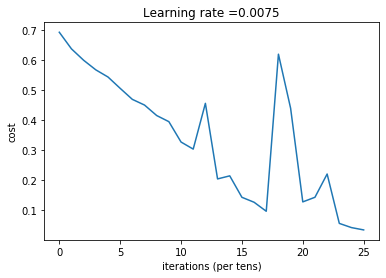

In [17]:
# Train model
layers_dims = [49152, 20, 7, 5, 1] # 4-layer model
parameters = L_layer_model(
    train_x[:, :int(len(arrData) * .20)], train_y[:, :int(len(arrData) * .20)], layers_dims, 
    learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

__Results:__

In [21]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.7857142857142857

Dev set: 
Accuracy: 0.6866666666666668


Now, we will increase the number of examples we use in our model.
### 5.2 - Increase # of examples to 50%.
__Data separation:__
- __50% train (Prev: 20%)__
- 15% dev
- 15% test

__Network structure:__
- layers_dims = [49152, 20, 7, 5, 1] #  4-layer model

__Learning Rate:__
- 0.0075

__Number of iterations:__
- 2500

Cost after iteration 0: 0.692939
Cost after iteration 2499: 0.226689


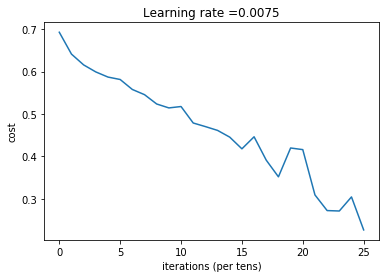

In [22]:
# Train model
layers_dims = [49152, 20, 7, 5, 1] # 4-layer model
parameters = L_layer_model(
    train_x[:, :int(len(arrData) * .50)], train_y[:, :int(len(arrData) * .50)], layers_dims, 
    learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

__Results:__

In [23]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.8821428571428571

Dev set: 
Accuracy: 0.7316666666666667


### 5.3 - Increase # of examples to 70%.
__Data separation:__
- __70% train (Prev: 20%)__
- 15% dev
- 15% test

__Network structure:__
- layers_dims = [49152, 20, 7, 5, 1] #  4-layer model

__Learning Rate:__
- 0.0075

__Number of iterations:__
- 2500

Cost after iteration 0: 0.692974
Cost after iteration 2499: 0.335077


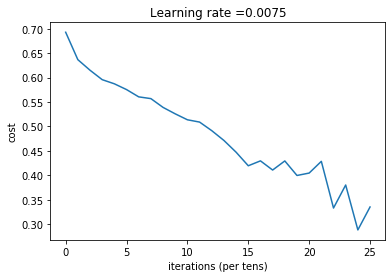

In [24]:
# Train model
layers_dims = [49152, 20, 7, 5, 1] # 4-layer model
parameters = L_layer_model(
    train_x, train_y, layers_dims, 
    learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

__Results:__

In [25]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.8660714285714286

Dev set: 
Accuracy: 0.6783333333333333


Even though using the 50% train size gave us better results than the other models, we still decided to use __the 70% train size__ as our new model, because we think that using more examples will give us better, more accurate results in the long run when doing other experiments with different architectures in the next steps.

### 5.4 Increase number of layers to 5 layers
__Data separation:__
- __70% train (Prev: 20%)__
- 15% dev
- 15% test

__Network structure:__
- __layers_dims = [49152, 20, 7, 5, 3, 1] (Prev: [49152, 20, 7, 5, 1])__

__Learning Rate:__
- 0.0075

__Number of iterations:__
- 2500

Cost after iteration 0: 0.693275
Cost after iteration 2499: 0.033342


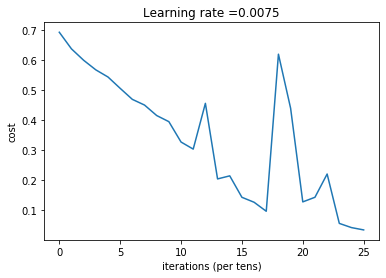

In [17]:
# Train model
layers_dims = [49152, 20, 7, 5, 3, 1] #  5-layer model
parameters = L_layer_model(
    train_x, train_y, layers_dims, Increase number of layers
    learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

__Results:__

In [21]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.7857142857142857

Dev set: 
Accuracy: 0.6866666666666668


### 5.5 Increase number of neurons and 5 layers
__Data separation:__
- __70% train (Prev: 20%)__
- 15% dev
- 15% test

__Network structure:__
- __layers_dims = [49152, 29, 13, 7, 3, 1] (Prev: [49152, 20, 7, 5, 1])__

__Learning Rate:__
- 0.0075

__Number of iterations:__
- 2500

Cost after iteration 0: 0.693275
Cost after iteration 2499: 0.033342


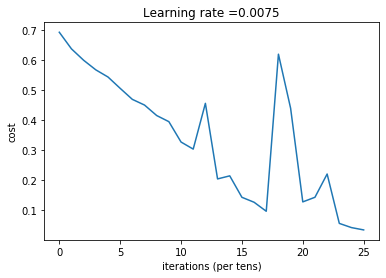

In [17]:
# Train model
layers_dims = [49152, 29, 13, 7, 3, 1] #  5-layer model
parameters = L_layer_model(
    train_x, train_y, layers_dims, 
    learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

__Results:__

In [21]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.7857142857142857

Dev set: 
Accuracy: 0.6866666666666668


We tried with __one extra layer__ and __one extra layer with more neurons__, we noticed that more neurons did not help us to get a better accuracy, so maybe there is no need right now for us to add more neurons in each layer, instead we will try adding another layer, because that might help us a bit more. 
We will now try with __six layers and with different learning rates and iterations__.

### 5.6 6 layers with learning rate of 0.001 and 1500 iterations
__Data separation:__
- __70% train (Prev: 20%)__
- 15% dev
- 15% test

__Network structure:__
- __layers_dims = [49152, 17, 11, 8 ,5, 3, 1] (Prev: [49152, 20, 7, 5, 3, 1])__

__Learning Rate:__
- __0.001 (Prev: 0.0075)__

__Number of iterations:__
- __1500 (Prev: 2500)__

Cost after iteration 0: 0.693275
Cost after iteration 2499: 0.033342


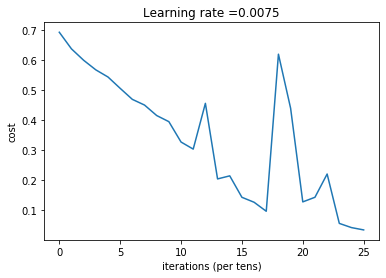

In [17]:
# Train model
layers_dims = [49152, 17, 11, 8 ,5, 3, 1] #  6 layer model
parameters = L_layer_model(
    train_x, train_y, layers_dims, 
    learning_rate = 0.001, num_iterations = 1500, print_cost = True)

__Results:__

In [21]:
# Test vs training set
print("Training set: ")
pred_train = predict(train_x, train_y, parameters)
print()
# Test vs dev set
print("Dev set: ")
pred_dev = predict(dev_x, dev_y, parameters)

Training set: 
Accuracy: 0.7857142857142857

Dev set: 
Accuracy: 0.6866666666666668


### Testing

In [ ]:
pred_train = predict(train_x, train_y, parameters)

In [ ]:
pred_train = predict(dev_x, dev_y, parameters)

In [ ]:
pred_test = predict(test_x, test_y, parameters)